In [136]:
from datasets import load_dataset
import numpy as np
import subprocess
import difflib
import autopep8
import requests as req
import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas()
import json
import tree_sitter_python as tspython
import tree_sitter_java as tsjava

from tree_sitter import Language, Parser

## Datset loading and preprocessing

We only use logic errors and perform the following preprocessing steps:
- Remove examples containing syntax errors
- Remove blank lines
- Format the buggy code and the solution
- Remove comments

In [137]:
dataset = load_dataset("Rtian/DebugBench")
df = pd.DataFrame(dataset['test'])
filtered_df = df[df['category'] == 'logic error'].copy()

In [ ]:
PY_LANGUAGE = Language(tspython.language(), "python")
JAVA_LANGUAGE = Language(tsjava.language(), "java")

py_parser = Parser()
py_parser.set_language(PY_LANGUAGE)

java_parser = Parser()
java_parser.set_language(JAVA_LANGUAGE)

def remove_blank_lines(text):
    return "\n".join([s.rstrip() for s in text.splitlines() if s.strip()])
    
def format_cpp_code(code):
    try:
        process = subprocess.Popen(['clang-format', '--style=file:./clang-format.txt'], 
                                   stdin=subprocess.PIPE, 
                                   stdout=subprocess.PIPE, 
                                   stderr=subprocess.PIPE)
        formatted_code, errors = process.communicate(input=code.encode())
        if process.returncode != 0:
            print("Error cpp formatting code: ", errors.decode())
            return code
        process = subprocess.Popen(['g++', '-fpreprocessed', '-dD', '-E', '-P', '-'],
                                   stdin=subprocess.PIPE,
                                   stdout=subprocess.PIPE,
                                   stderr=subprocess.PIPE)
        formatted_code, errors = process.communicate(input=formatted_code)

        
        if process.returncode != 0:
            print("Error cpp formatting code: ", errors.decode())
            return code
        
        return remove_blank_lines(formatted_code.decode())
    except Exception as e:
        print(f"An exception occurred: {e}")
        return code
    
def format_python_code(code):
    try:
        # ignore errors to prevent autopep from running forever
        formatted_code = autopep8.fix_code(code, options={'ignore': ['E']})
    except Exception as e:
        print(f"An exception occurred: {e}")
        return code
    bytes_code = bytes(formatted_code, "utf-8")
    array = bytearray(bytes_code)
    tree = py_parser.parse(bytes_code)
    def traverse(node):
        if node.type == 'comment':
            array[node.start_byte:node.end_byte]=(node.end_byte - node.start_byte) * b" "
            return 
        elif node.child_count == 0:
            return
        else:
            for child in node.children:
                traverse(child)
            return
    traverse(tree.root_node)
    cleaned_code = array.decode("utf-8")
    return remove_blank_lines(cleaned_code)


def format_java_code(code):
    try:
        process = subprocess.Popen(['clang-format', '--style=file:./clang-format-java.txt', '--assume-filename=Main.java'], 
                                   stdin=subprocess.PIPE, 
                                   stdout=subprocess.PIPE, 
                                   stderr=subprocess.PIPE)
        formatted_code, errors = process.communicate(input=code.encode())
        
        if process.returncode != 0:
            print("Error formatting java code: ", errors.decode())
            return code
        
    except Exception as e:
        print(f"An exception occurred: {e}")
        return code
    
    array = bytearray(formatted_code)
    tree = java_parser.parse(formatted_code)
    def traverse(node):
        if "comment" in node.type:
            #print(f"Removed comment: {array[node.start_byte:node.end_byte].decode('utf-8')}")
            array[node.start_byte:node.end_byte]=(node.end_byte - node.start_byte) * b" "
            return 
        elif node.child_count == 0:
            return
        else:
            for child in node.children:
                traverse(child)
            return
    
    traverse(tree.root_node)
    cleaned_code = array.decode("utf-8")
    return remove_blank_lines(cleaned_code)

def format_code(code, language):
    if language == "python3":
        return format_python_code(code)
    elif language == "cpp":
        return format_cpp_code(code)
    elif language == "java":
        return format_java_code(code)
    else:
        print(f"Unsupported language: {language}")
        return code

def format_entry(entry):
    buggy_code = entry['buggy_code']
    solution = entry['solution']
    return pd.Series({
        "buggy_code_formatted": format_code(buggy_code, entry['language']),
        "solution_formatted": format_code(solution, entry['language'])
    })
    
filtered_df[["buggy_code_formatted", "solution_formatted"]] = filtered_df.progress_apply(format_entry, axis=1)

formatted_df = filtered_df
formatted_df.to_csv("formatted_code.csv", index=False)

## Prompt the LLM
After the preprocessing, we now retrieve lines of code that are relevant for fixing the buggy code.

In [138]:
formatted_df = pd.read_csv("./notebooks/formatted_code.csv")


formatted_df['buggy_code'] = formatted_df['buggy_code'].apply(str)
formatted_df['buggy_code_formatted'] = formatted_df['buggy_code_formatted'].apply(str)

formatted_df['solution'] = formatted_df['solution'].apply(str)
formatted_df['solution_formatted'] = formatted_df['solution_formatted'].apply(str)

In [ ]:
def find_changed_lines(file1_contents, file2_contents, print_diff=False):
    diff = difflib.ndiff(file1_contents.splitlines(), file2_contents.splitlines())
    
    changed_lines = set() # change or insert below

    current_line_number = 0
    pending_change = False
    for line in diff: 
        if print_diff:
            print(f"{current_line_number}: {line}")
 
        if line.startswith('  '):
            current_line_number += 1
            pending_change = False
        else:
            if line.startswith('- '):  # Lines in file1 but not in file2
                pending_change = True
                current_line_number += 1
                changed_lines.add(current_line_number)
            elif line.startswith('+ '):  # Lines in file2 but not in file1
                if pending_change:
                    pending_change = False
                else:
                    changed_lines.add(current_line_number)
    return list(changed_lines)

In [ ]:
log_file_name = "output_with_context2.json"
results_file_name = "results_formatted_context.csv"

log_file = open(log_file_name, "w")
log_file.write("[")

def retrieve_relevant_lines_for_entry(entry):
    buggy_code = entry['buggy_code_formatted']
    solution = entry['solution_formatted']
    num_lines = buggy_code.count('\n')
    changed_lines = find_changed_lines(buggy_code, solution)

    data = {"code": buggy_code, "language": entry['language'], "context": entry["question"]}
    success = True
    response_json = []
    try:
        resp = req.post("http://delos.eaalab.hpi.uni-potsdam.de:8010/highlight-code/", json=data)
        try:
            response_json = resp.json()
        except:
            print("Json parsing failed")
            print(resp.text())
    except:
        print("Request failed")
        success = False    

    predicted_lines = []
    suggestions = []
    descriptions = []
    actions = []
    for item in response_json:
        line_number = int(item.get('line_number', "1"))
        suggestions.append(item.get("description", ""))
        descriptions.append(item.get("suggestion", ""))
        predicted_lines.append(line_number)
        actions.append(item.get("action", ""))

    result = {
        'buggy_code': buggy_code,
        'solution': solution,
        'changed_lines': changed_lines,
        'predicted_lines': predicted_lines,
        'num_lines': num_lines,
        'success': success,
        'suggestions': suggestions,
        'descriptions': descriptions,
        'actions': actions,
    }
    log_file.write(f'{json.dumps(result)},')
    log_file.flush()
    return result



filtered_df = formatted_df.iloc[318:]
print(filtered_df.head())
results = filtered_df.progress_apply(retrieve_relevant_lines_for_entry, axis=1)

log_file.write("]")
log_file.close()
results_df = pd.DataFrame(results.tolist())
results_df.to_csv(results_file_name, index=False)

In [119]:
skip = False
if not skip:
    import ast
    df = pd.read_csv("./notebooks/results_formatted.csv")
    #df['num_clusters'] = df['changed_lines'].apply(ast.literal_eval[1])
    df['changed_lines'] = df['changed_lines'].apply(ast.literal_eval)
    df['predicted_lines'] = df['predicted_lines'].apply(ast.literal_eval)
    df['actions'] = df['actions'].apply(ast.literal_eval)
    # tell pythont hat buggy_code is a string
    df['buggy_code'] = df['buggy_code'].apply(str)
    df['solution'] = df['solution'].apply(str)
else:
    df = results_df.copy()


In [120]:
## remove changed lines and num_clusters from the results
df = df.drop(columns=['changed_lines'])
## recompute changed lines
df['changed_lines'] = df.apply(lambda x: find_changed_lines(x['buggy_code'], x['solution']), axis=1)
#df.to_csv("results_formatted.csv", index=False)

In [121]:
# Use values to ignore underlying indexes
df['language'] = filtered_df['language'].values
df['level'] = filtered_df['level'].values
df['category'] = filtered_df['category'].values


In [122]:
success_df = df[df["success"]]
# https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
# We need the following line when working with success_df instead of df
#pd.options.mode.copy_on_write = False
print(f'Number of successful requests: {len(success_df)}')
print(f'Number of unsuccessful requests: {len(df) - len(success_df)}')
print(df.iloc[0])

Number of successful requests: 564
Number of unsuccessful requests: 26
buggy_code         class Solution {\n   public:\n    long long fa...
solution           class Solution {\n   public:\n    long long fa...
predicted_lines                                          [5, 13, 23]
num_lines                                                         24
success                                                         True
suggestions        ['The function calculates the factorial of n +...
descriptions       ['Change n + 1 to n in the recursive call.', '...
actions                               [change, change, insert_above]
changed_lines                                                    [5]
language                                                         cpp
level                                                           easy
category                                                 logic error
Name: 0, dtype: object


In [123]:
eval_df = success_df.copy()


In [124]:
def create_labels(row):
    labels = pd.Series([0] * (row['num_lines'] + 1)) # Why +1? 
    for line in row['changed_lines']:
        if line > row['num_lines'] +1:
            print(f"Error {line} exceeds {row['num_lines']}")
            continue
        if line == 0: # Special case in which an insertion before the first line is required.
            labels[0] = 1
        else: 
            labels[line-1] = 1 # lines are 1-indexed so we subtract 1
    assert len(labels) == row['num_lines']+1, f"{len(labels)} != {row['num_lines']}"
    return labels.tolist()

def create_predictions(row):
    predictions = pd.Series([0] * (row['num_lines'] +1))
    for i, line in enumerate(row['predicted_lines']):
        action = row['actions'][i]
        relevant_line = line
        if action == "insert_below":
            pass
        elif action == "insert_above":
            relevant_line -= 1
        elif action == "change" or action == "delete" or action == "remove" or action == "modify":
            pass
        else:
            print(f"Unknown action: {action}")
            continue

        if relevant_line > row['num_lines'] + 1:
            print(f"Error {line} exceeds {row['num_lines']}")
            continue
        predictions[relevant_line-1] = 1
    assert len(predictions) == row['num_lines'] +1, f"{len(labels)} != {row['num_lines']}"
    return predictions.tolist()

eval_df['labels'] = eval_df.apply(create_labels, axis=1)
eval_df['predictions'] = eval_df.apply(create_predictions, axis=1)

labels = np.array([b for a in eval_df['labels'].values for b in a])
predictions = np.array([b for a in eval_df['predictions'].values for b in a])
assert len(labels) == len(predictions)

Unknown action: no_change
Unknown action: no_change
Unknown action: insert_inside
Unknown action: insert_inside
Unknown action: move
Unknown action: remove_one_modulo
Unknown action: no_change
Unknown action: move
Unknown action: move
Unknown action: add
Unknown action: add
Unknown action: move
Unknown action: move
Unknown action: move_outside
Unknown action: move_outside
Unknown action: move_outside
Unknown action: external_action
Unknown action: replace
Unknown action: replace
Unknown action: no_change
Unknown action: no_change
Unknown action: move_inside
Unknown action: no_action
Unknown action: investigate
Unknown action: comment out
Unknown action: comment out
Unknown action: replace
Unknown action: replace
Unknown action: keep
Unknown action: keep
Unknown action: check
Unknown action: check
Unknown action: check
Unknown action: replace
Unknown action: replace
Unknown action: replace
Unknown action: add
Unknown action: add_comment
Unknown action: add_code
Unknown action: move
Unkn

In [125]:
from sklearn.metrics import confusion_matrix, f1_score

def entry_based_metrics(entry):
    labels = np.array(entry['labels'])
    predictions = np.array(entry['predictions'])
    conf_matrix = confusion_matrix(labels, predictions, labels=[0, 1])

    return {'tn': conf_matrix[0][0],
            'fn': conf_matrix[1][0],
            'fp': conf_matrix[0][1],
            'tp': conf_matrix[1][1],
            'f1': f1_score(labels, predictions)}



results = eval_df.progress_apply(entry_based_metrics, axis=1)

results_df = pd.DataFrame(results.tolist())

eval_df['tp'] = results_df['tp']
eval_df['fp'] = results_df['fp']
eval_df['fn'] = results_df['fn']
eval_df['tn'] = results_df['tn']
eval_df['f1'] = results_df['f1']


  0%|          | 0/564 [00:00<?, ?it/s]

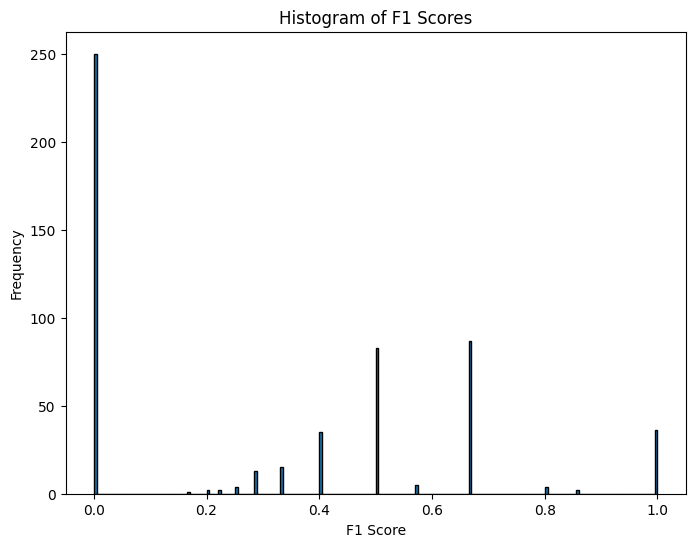

In [126]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.hist(eval_df['f1'], bins=200, edgecolor='black')
plt.title('Histogram of F1 Scores')
plt.xlabel('F1 Score')
plt.ylabel('Frequency')
plt.show()

In [127]:
from IPython.display import display, HTML
res_df = eval_df.sort_values(by='f1', ascending=False).head(2)#[['buggy_code', 'solution', 'changed_lines', 'predicted_lines']]

def pretty_print(input_df):
    return display(HTML(input_df.to_html().replace("\\n", "<br>")))

pretty_print(res_df)

,buggy_code,solution,predicted_lines,num_lines,success,suggestions,descriptions,actions,changed_lines,language,level,category,labels,predictions,tp,fp,fn,tn,f1
158,"class Solution { public: double f(int i, int j, int k, int n, vector<vector<vector<double>>>& dp) { if (k == 0) return 1.0; if (dp[i][j][k] != -1.0) return dp[i][j][k]; int dx[] = {-2, -2, -1, 1, 2, 2, 1, -1}, dy[] = {-1, 1, 2, 2, 1, -1, -2, -2}; double ans = 0.0; for (int t = 0; t < 8; t++) { int nx = i + dx[t], ny = j + dy[t]; if (nx >= 0 && nx < n && ny >= 0 && ny < n) { ans += f(nx, ny, k - 1, n, dp); } } return dp[i][j][k] = ans / 8; } double knightProbability(int n, int k, int row, int column) { vector<vector<vector<double>>> dp(n, vector<vector<double>>(n, vector<double>(k + 1, -1.0))); double ct = f(row, column, k, n, dp); for (int i = 0; i < k; i++) { ct = ct / 8; } return ct; }};","class Solution { public: double f(int i, int j, int k, int n, vector<vector<vector<double>>>& dp) { if (k == 0) return 1.0; if (dp[i][j][k] != -1.0) return dp[i][j][k]; int dx[] = {-2, -2, -1, 1, 2, 2, 1, -1}, dy[] = {-1, 1, 2, 2, 1, -1, -2, -2}; double ans = 0.0; for (int t = 0; t < 8; t++) { int nx = i + dx[t], ny = j + dy[t]; if (nx >= 0 && nx < n && ny >= 0 && ny < n) { ans += f(nx, ny, k - 1, n, dp); } } return dp[i][j][k] = ans; } double knightProbability(int n, int k, int row, int column) { vector<vector<vector<double>>> dp(n, vector<vector<double>>(n, vector<double>(k + 1, -1.0))); double ct = f(row, column, k, n, dp); for (int i = 0; i < k; i++) { ct = ct / 8; } return ct; }};","[9, 14, 18, 20]",23,True,"['The code may access out of bounds memory if i or j are on the edge of the board.', 'The code may result in division by zero if k is 0.', 'The code may result in an infinite recursion if k is not properly decremented in the recursive call.', 'The code may result in an incorrect result if the value of ct is too small.']","['Add bounds checking to ensure nx and ny are within the board.', 'Add a check to ensure k is not zero before dividing.', 'Decrement k in the recursive call to f().', 'Consider using a more accurate method to calculate the probability.']","[insert_above, insert_above, change, change]",[14],cpp,medium,logic error,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0]",2.0,0.0,0.0,19.0,1.0
327,"class Solution { public List<List<Integer>> combinationSum(int[] candidates, int target) { List<List<Integer>> result = new ArrayList<>(); List<Integer> currentSubset = new ArrayList<>(); findCombination(0, target, candidates, currentSubset, result); return result; } public static void findCombination(int index, int target, int[] candidates, List<Integer> currentSubset, List<List<Integer>> result) { if (index == candidates.length) { if (target == 0) { result.add(new ArrayList<>(currentSubset)); } return; } if (candidates[index] <= target) { currentSubset.add(candidates[index]); findCombination(index + 1, target - candidates[index], candidates, currentSubset, result); currentSubset.remove(currentSubset.size() - 1); } findCombination(index + 1, target, candidates, currentSubset, result); }}","class Solution { public List<List<Integer>> combinationSum(int[] candidates, int target) { List<List<Integer>> result = new ArrayList<>(); List<Integer> currentSubset = new ArrayList<>(); findCombination(0, target, candidates, currentSubset, result); return result; } public static void findCombination(int index, int target, int[] candidates, List<Integer> currentSubset, List<List<Integer>> result) { if (index == candidates.length) { if (target == 0) { result.add(new ArrayList<>(currentSubset)); } return; } if (candidates[index] <= target) { currentSubset.add(candidates[index]); findCombination(index, target - candidates[index], candidates, currentSubset, result); currentSubset.remove(currentSubset.size() - 1); } findCombination(index + 1, target, candidates, currentSubset, result); }}

In [128]:
def aggregate_and_print(input_df):
    tn = input_df['tn'].sum()
    fn = input_df['fn'].sum()
    tp = input_df['tp'].sum()
    fp = input_df['fp'].sum()
    print([tn, fp], "\n",
           [fn, tp])

In [129]:
print("differen levels")
easy_df = eval_df[eval_df['level'] == 'easy']
aggregate_and_print(easy_df)
mid_df = eval_df[eval_df['level'] == 'medium']
aggregate_and_print(mid_df)
hard_df = eval_df[eval_df['level'] == 'hard']
aggregate_and_print(hard_df)

print("non zero")
non_zero_df = eval_df[eval_df['suggestions'].apply(lambda x: len(x) > 0)]
aggregate_and_print(non_zero_df)

print("zero")
zero_df = eval_df[eval_df['suggestions'].apply(lambda x: len(x) == 0)]
aggregate_and_print(zero_df)

print("error types")
easy_df = eval_df[eval_df['category'] == 'syntax error']
aggregate_and_print(easy_df)
mid_df = eval_df[eval_df['category'] == 'multiple error']
aggregate_and_print(mid_df)
hard_df = eval_df[eval_df['category'] == 'logic error']
aggregate_and_print(hard_df)
ref_df = eval_df[eval_df['category'] == 'reference error']
aggregate_and_print(ref_df)

differen levels
[3231.0, 421.0] 
 [146.0, 125.0]
[4317.0, 553.0] 
 [168.0, 144.0]
[1769.0, 197.0] 
 [59.0, 48.0]
non zero
[9317.0, 1171.0] 
 [373.0, 317.0]
zero
[0.0, 0.0] 
 [0.0, 0.0]
error types
[0.0, 0.0] 
 [0.0, 0.0]
[0.0, 0.0] 
 [0.0, 0.0]
[9317.0, 1171.0] 
 [373.0, 317.0]
[0.0, 0.0] 
 [0.0, 0.0]


In [130]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, balanced_accuracy_score

accuracy = accuracy_score(labels, predictions)
balanced_acc = balanced_accuracy_score(labels, predictions)
precision = precision_score(labels, predictions)
recall = recall_score(labels, predictions)
f1 = f1_score(labels, predictions)
conf_matrix = confusion_matrix(labels, predictions)


print(f'Accuracy: {accuracy}')
print(f'Balanced Accuracy: {balanced_acc}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Confusion Matrix:\n{conf_matrix}')

Accuracy: 0.8600085726532362
Balanced Accuracy: 0.6714708213976752
Precision: 0.21159974506054813
Recall: 0.45604395604395603
F1 Score: 0.2890727035263387
Confusion Matrix:
[[9700 1237]
 [ 396  332]]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.6666666666666666
Area 0.6714708213976751


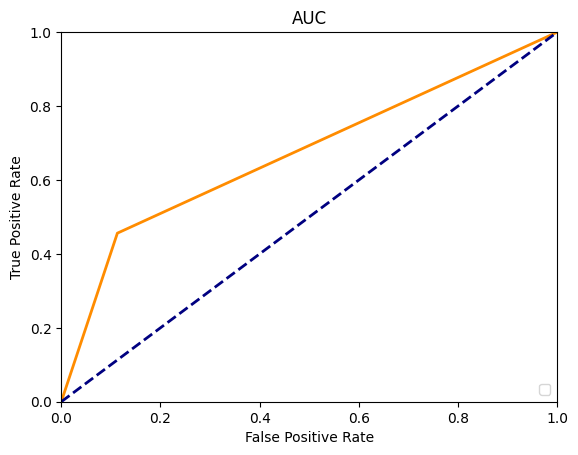

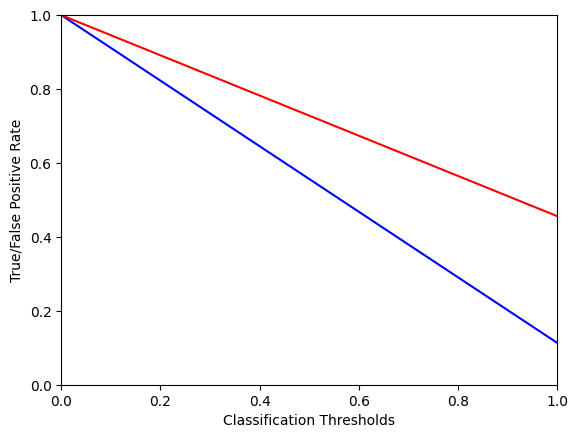

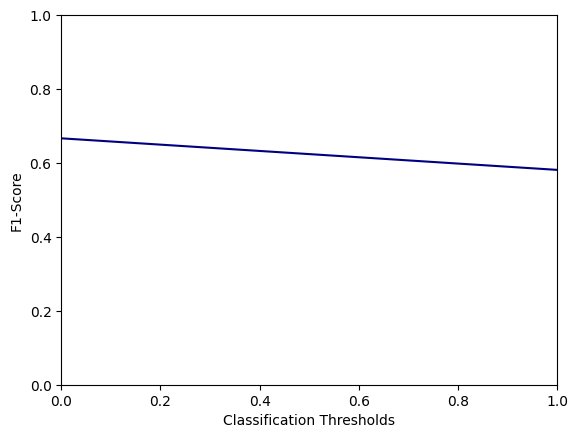

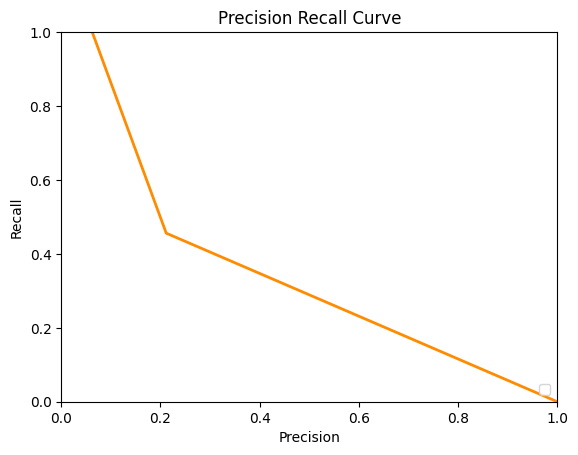

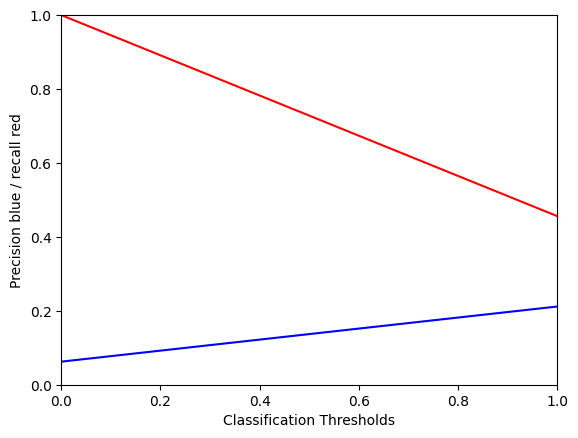

In [131]:
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc, precision_recall_curve

num_positives = labels.sum()

fpr, tpr, thresholds = roc_curve(labels, predictions)
precision, recall, thresholds2 = precision_recall_curve(labels, predictions)
fn = [(num_positives) - tp * num_positives for tp in tpr]
f1 = [(2*tpr[i]*num_positives)/(2*tpr[i]*num_positives + fpr[i]*num_positives + fn[i]) for i in range(len(fpr))]
print(max(f1))

roc_auc = auc(fpr, tpr)
print("Area", roc_auc)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC')
plt.legend(loc='lower right')

plt.figure()
plt.plot(thresholds, fpr, color='blue')
plt.plot(thresholds, tpr, color='red')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Classification Thresholds')
plt.ylabel('True/False Positive Rate')

plt.figure()
plt.plot(thresholds, f1, color='navy')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Classification Thresholds')
plt.ylabel('F1-Score')

plt.figure()
plt.plot(precision, recall, color='darkorange', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision Recall Curve')
plt.legend(loc='lower right')

length = min(len(precision), len(recall))
plt.figure()
plt.plot(thresholds2, precision[:length-1], color='blue')
plt.plot(thresholds2, recall[:length-1], color='red')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Classification Thresholds')
plt.ylabel('Precision blue / recall red')

plt.show()